In [32]:
%matplotlib inline

In [33]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [181]:
# utility function for colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable
def add_colorbar(fig, ax, im):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

# Setup

In [30]:
import hydra
import torch
import matplotlib.pyplot as plt
from bliss.encoder import Encoder
from hydra import compose, initialize
from hydra.utils import instantiate

In [20]:
# GPU to be used (first one available)
device = torch.device('cuda:0')

In [21]:
# config file containing parameters of models to run
with initialize(config_path="../../sdss_galaxies/config"):
    cfg = compose("config", overrides=[])

In [22]:
# example cfg (hydra+OmegaConf, see: https://hydra.cc/ and https://omegaconf.readthedocs.io)

# model config
import omegaconf
omegaconf.OmegaConf.to_container(cfg.models.detection_encoder)

{'_target_': 'bliss.models.detection_encoder.DetectionEncoder',
 'input_transform': {'_target_': 'bliss.models.detection_encoder.ConcatBackgroundTransform'},
 'n_bands': '${models.decoder.n_bands}',
 'tile_slen': '${models.decoder.tile_slen}',
 'ptile_slen': 52,
 'max_detections': '${models.prior.max_sources}',
 'channel': 8,
 'spatial_dropout': 0.0,
 'dropout': 0.0,
 'hidden': 128,
 'annotate_probs': True,
 'slack': 1.0}

In [24]:
# dataset config
omegaconf.OmegaConf.to_container(cfg.datasets.galsim_blends)

{'_target_': 'bliss.datasets.galsim_galaxies.GalsimBlends',
 'prior': {'_target_': 'bliss.models.galsim_decoder.UniformGalsimPrior',
  'single_galaxy_prior': '${datasets.sdss_galaxies.prior}',
  'max_n_sources': 8,
  'mean_sources': 3,
  'max_shift': 0.5,
  'galaxy_prob': 0.7},
 'decoder': {'_target_': 'bliss.models.galsim_decoder.FullCatalogDecoder',
  'single_galaxy_decoder': '${datasets.sdss_galaxies.decoder}',
  'slen': 40,
  'bp': 24},
 'background': '${datasets.sdss_galaxies.background}',
 'tile_slen': 4,
 'max_sources_per_tile': 1,
 'num_workers': 10,
 'batch_size': 32,
 'n_batches': 10,
 'fix_validation_set': True,
 'valid_n_batches': 50}

# Create example images

In [142]:
# will pick only bright galaxies for this demo 
# also ensure every image has enough sources
cfg.datasets.galsim_blends.prior.mean_sources = 4
cfg.datasets.galsim_blends.prior.single_galaxy_prior.min_flux = 1e4
cfg.datasets.galsim_blends.prior.galaxy_prob = 1.0
dataset = instantiate(cfg.datasets.galsim_blends)

In [143]:
batch = next(iter(dataset.train_dataloader()))

In [144]:
# batch size = 32
print(batch['images'].shape)
print(batch['images'].device)

torch.Size([32, 1, 88, 88])
cpu


In [145]:
# other keys
batch.keys()

dict_keys(['images', 'background', 'n_sources', 'locs', 'galaxy_bools', 'star_bools', 'galaxy_params', 'star_fluxes', 'star_log_fluxes', 'mags', 'ellips', 'snr', 'blendedness'])

In [162]:
# source parameters are 'per-tile'
# 10x10 total tiles
print(batch['n_sources'].shape) # number of sources per tile
print(batch['locs'].shape) #normalized locations per tile 
print(batch['galaxy_params'].shape) # galaxy latent variables

torch.Size([32, 10, 10])
torch.Size([32, 10, 10, 1, 2])
torch.Size([32, 10, 10, 1, 7])


In [149]:
# convert to 'per-image'
# bliss contains a specific 'tile' catalog and 'full' catalog object to aid this process
# tiles are 4x4 pixels
from bliss.catalog import TileCatalog, FullCatalog
tile_params_dict = {k:v for k,v in batch.items() if k not in {'images', 'background'}}
tile_catalog = TileCatalog(4, tile_params_dict) # tile_slen, n_tiles_w, n_tiles_h, dict of parars
truth = tile_catalog.to_full_params() # truth full catalog

In [151]:
truth.plocs.shape # pixel locations (batch_size, max_n_sources, 2)

torch.Size([32, 8, 2])

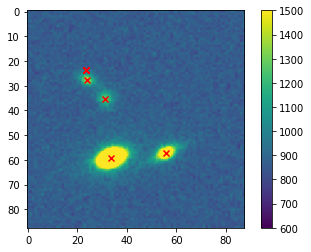

In [155]:
# example image with true locations plotted
xpeak, ypeak = truth.plocs[1, :, 1] + 24 - 0.5, truth.plocs[1, :, 0] + 24 - 0.5 # 24 = border padding, # 24 = border padding, 0.5 is matplotlib
xpeak,ypeak = xpeak.cpu().numpy(), ypeak.cpu().numpy()
plt.scatter(xpeak, ypeak, color='r', marker='x')
plt.imshow(batch['images'][1,0], interpolation=None, vmin=600, vmax=1500)
plt.colorbar()

# Load models

In [156]:
# load encoders with (pre-trained) neural network weights

# detection encoder
location = instantiate(cfg.models.detection_encoder).to(device).eval()
location.load_state_dict(
    torch.load(cfg.plots.location_checkpoint, map_location=location.device)
)

# classification encoder
binary = instantiate(cfg.models.binary).to(device).eval()
binary.load_state_dict(torch.load(cfg.plots.binary_checkpoint, map_location=device))

# blended galaxy encoder
galaxy = instantiate(cfg.models.galaxy_encoder).to(device).eval()
galaxy.load_state_dict(torch.load(cfg.plots.galaxy_checkpoint, map_location=device))

# bliss has a nice class that puts all of them together for ease-of-use
encoder = Encoder(
    location.eval(),
    binary.eval(),
    galaxy.eval(),
    n_images_per_batch=10,
    n_rows_per_batch=15,
)
encoder = encoder.to(device)

In [157]:
# load decoder model for reconstruction
decoder = instantiate(cfg.models.decoder).to(device).eval()

In [158]:
# prepare background estimate that needs to be fed in separately
background_obj = instantiate(cfg.datasets.galsim_blends.background)
background = background_obj.sample(batch['images'].shape)

In [159]:
# obtain prediction (variational mode) per tile on the images we produced from generative model
tile_est = encoder.variational_mode(batch['images'], background)

Encoding ptiles: 4it [00:00, 14.19it/s]


In [161]:
# check it is (per-tile)
tile_est['galaxy_params'].shape

torch.Size([32, 10, 10, 1, 8])

In [165]:
# per tile catalogs can easy be converted to full catalog on images 
pred = tile_est.to_full_params() # predicted full catalog

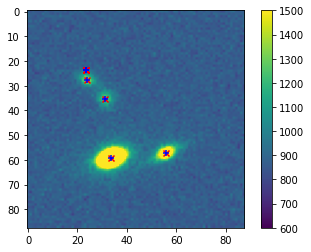

In [166]:
# plot truth and estimated locations
xpeak1, ypeak1 = truth.plocs[1, :, 1] + 24 - 0.5, truth.plocs[1, :, 0] + 24 - 0.5 # 24 = border padding
xpeak1,ypeak1 = xpeak1.cpu().numpy(), ypeak1.cpu().numpy()

xpeak2, ypeak2 = pred.plocs[1, :, 1] + 24 - 0.5, pred.plocs[1, :, 0] + 24 - 0.5 # 24 = border padding, 0.5 is matplotlib
xpeak2,ypeak2 = xpeak2.cpu().numpy(), ypeak2.cpu().numpy()
plt.scatter(xpeak1, ypeak1, color='r', marker='x')
plt.scatter(xpeak2, ypeak2, color='b', marker='+')

plt.imshow(batch['images'][1,0], interpolation=None, vmin=600, vmax=1500)
plt.colorbar()

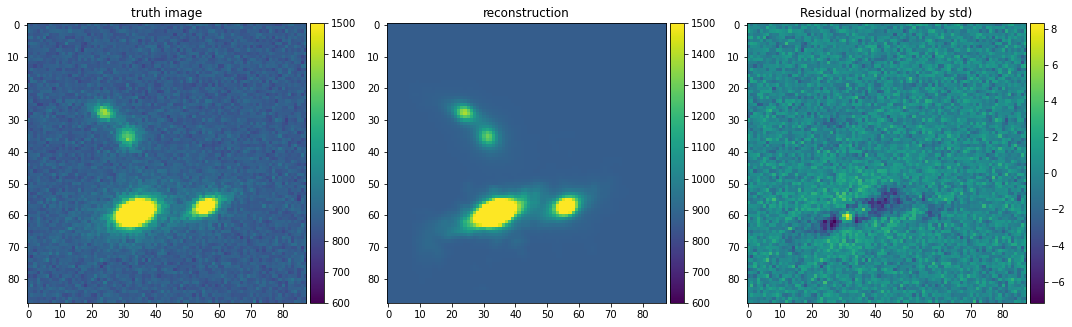

In [184]:
# plot true image and (noiseless) reconstruction side by side
# decoder is per-tile so takes as input 'predicted tile catalog'
image = batch['images'][1,0]
recon = decoder.render_images(tile_est)[1,0].detach().cpu().numpy() + background[1,0].numpy()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
im1 = ax1.imshow(image, interpolation=None, vmin=600, vmax=1500)
im2 = ax2.imshow(recon, interpolation=None, vmin=600, vmax=1500)
im3 = ax3.imshow((image - recon)/np.sqrt(recon), interpolation=None)


ax1.set_title('truth image')
ax2.set_title('reconstruction')
ax3.set_title('Residual (normalized by std)')
add_colorbar(fig, ax1, im1)
add_colorbar(fig, ax2, im2)
add_colorbar(fig, ax3, im3)
plt.tight_layout()

In [ ]:
# NOTE: Samples can be drawn from variational distribution too instead of using
# variational distribution
# left for later tutorial :-)